In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/GitHub/ML-for-PhaseField/models/Julia`


We will solve the following Allen-Cahn problem in 2D:

$$
\begin{align}
\frac{1}{M}{\partial_t\phi}&=\underbrace{\partial_{x}^{2}\phi+\partial_{y}^{2}\phi}_{\mathrm{Laplace-Operator}}-\frac{2}{\xi^2}{\partial_\phi g(\phi)}-\frac{\mu_{0}}{3\Gamma\xi}{\partial_\phi h(\phi)}. \\
\phi \in \R^2 \\
\phi(x,0) = \phi_0 \\
\frac{\partial \phi}{\partial x} = 0 \quad\forall x \in \partial \Omega
\end{align}
$$

Using the method of lines (MOL) on a Finite Difference grid, i.e. we discretize the problem in all dimensions but one.

With this approach, we obtain a set of ordinary differential equations that we can subsequently solve using any suitable high-order method.

In [2]:
using DifferentialEquations, Plots
gr()

Plots.GRBackend()

We will denote the partial derivatives of the source terms with `dg` and `dh` respectively

In [3]:
function dg(ϕ)
    return 2.0 * ϕ * (1.0 - ϕ) * (1.0 - 2.0 * ϕ)
end

dg (generic function with 1 method)

In [4]:
function dh(ϕ)
    return 6.0 * ϕ * (1.0 - ϕ)
end

dh (generic function with 1 method)

In [5]:
function integral(ϕ, Δx)
    return sum(ϕ) * Δx^2
end

integral (generic function with 1 method)

We create a function to impose a Neumann boundary condition on our field:
$$
\frac{\partial \phi}{\partial x} = 0 \quad \forall x \in \partial \Omega
$$

To do this, we simply need to set the derivative field at the domain edge equal to its inward neighbor so that there is no net flux present.

Here, we make use of the broadcasting capabilities of `Julia` by using the dot operator `.`. This tells the compiler to perform the operation element-wise although we pass arrays as arguments. This can be very convenient and expose a very easy way of parallelism without any custom, fancy loops.

In [6]:
function neumann!(ϕ)
    # left
    ϕ[1,:] .= ϕ[2,:]
    # Right
    ϕ[end,:] .= ϕ[end-1,:]
    # Top
    ϕ[:,end] .= ϕ[:,end-1]
    # Bottom
    ϕ[:,1] .= ϕ[:,2]
    return nothing
end

neumann! (generic function with 1 method)

We define the laplacian $\Delta$ using a 5-point central difference stencil. Note that we omit the boundary points when visiting each point of the derivative field $d\phi$ as we would otherwise run into bounds errors.

While we're at it writing loops, we call our source terms `dg` and `dh` simultaneously as the compiler would otherwise have to figure out the fusion of loops by itself.

We give the name of our function a bang `!` as this is Julia convention for functions that mutate their inputs. Those types of functions are quite common in high-performance code since they try to avoid allocations along the way.

With the macro `@inbounds`, we tell the compiler to omit bounds checks when executing the loop. We can get away with this here since we explicitly reference the size of the target arrays in the index bounds, so we are in bounds by definition. If you use this macro carelessly, the program might crash when a real out-of-bounds error occurs, so this is only advised to do if you're sure about what you're doing.

Finally, we can use `@views` to avoid extra allocations as this macro instructs the LLVM compiler to use pointers to the original array instead of making a temporary copy of it. This is a often used way of saving allocations.

In [7]:
function step!(dϕ,ϕ,p)
    @inbounds for i ∈ 2:size(ϕ,1)-1, k ∈ 2:size(ϕ,2)-1
            @views dϕ[i,k] = p[3] * ((ϕ[i+1,k] + ϕ[i-1,k] + ϕ[i,k+1] + ϕ[i,k-1] - 4*ϕ[i,k]) / p[5]^2 - 2.0/p[2]^2 * dg(ϕ[i,k]) + p[4]/(3.0*p[1]*p[2]) * dh(ϕ[i,k]))
        end
    return dϕ
end

step! (generic function with 1 method)

Let's see how our (hopefully non-allocating) semi-discretization fares performance-wise. To benchmark the implementation, we can use the very handy `BenchmarkTools.jl` package, where we get statistically meaningful results. Benchmarking is as simple as annotating the function call with the `@benchmark` macro and interpolating the arguments into the expression by appending a `$`:

In [8]:
using BenchmarkTools
ϕ = zeros(3,100)
dϕ = copy(ϕ);
p = ones(5);
@benchmark step!($dϕ,$ϕ,$p)

BenchmarkTools.Trial: 10000 samples with 204 evaluations.
 Range (min … max):  376.760 ns … 549.961 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     377.515 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   380.477 ns ±  11.178 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                ▃▃                                          ▁
  ██▃▁▁▁▅███▆▅▄▃▅▁▃▁██▄▁▃▁▁▁▁▄█▇▁▃▁▁▁▁▁▁▃▁▁▃▃▁▁▃▁▁▃▅▄▄▄▄▄▄▄▄▄▄▄ █
  377 ns        Histogram: log(frequency) by time        443 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

We don't see any allocations at all which is what we want ideally. Also, we can see that in neither case the Garbage Collector (GC) has to do any work. This can be considered an optimal case.

# Stationary phase front evolution problem

In [9]:
#Parameters of the model
Γ  = 1.0                  # [J/m^2] interface energy 
ξ  = 1.5                  # [m] phasefield interface width 
M  = 1.0                  # [m^2/s] kinetic coefficient 
μ₀ = 0.1                  # [J/m^3] bulk energy density difference (driving force)

0.1

We initialize a 1-D grid consisting of 100 grid points and package all our parameters into one vector that we can pass to the ODE solver.

In [10]:
mgrid = 3
ngrid = 100
Δx = 1.0
y₀ = 20.0

# Params vector
p = vcat(Γ,ξ,M,μ₀,Δx);

We state the initial condition as a 1D profile that is prescribed by the function:

$$
\phi_0(x,y) = \frac{1}{2}\left(1 - \mathrm{tanh}\frac{y-y_0}{\xi}\right)
$$

In [11]:
function phase_front(y,y₀,ξ)
    return 0.5 * (1.0 - tanh((y - y₀)/ξ))
end

phase_front (generic function with 1 method)

In [12]:
function position(ϕ,Δx,mgrid)
    return integral(ϕ,Δx) / (mgrid*Δx) + 0.5 * Δx
end

position (generic function with 1 method)

We assign the initial condition to our phase field array by using the tricks discussed before: disabling bounds checking, using views and broadcasting via `.` to avoid performance bottlenecks (although doesn't make a world of difference here since we're calling this code only once).

In [13]:
ϕ = zeros(ngrid,mgrid)
@inbounds for j ∈ 1:size(ϕ,1)
    @views ϕ[j,:] .= phase_front(j*Δx,y₀,ξ)
end

Plotting works very similar to MATLAB, where we simply call `plot` with the appropriate arguments.

First, we need to initialize a suitable grid for x. This can be done by specifying a range `start:step:end`. However, this returns an object of type `range` and not an array, which is what we want. To obtain that, we need to pass it to the `collect()` function. The way it's done here is by using the pipe syntax `|>` which does the same as if we called `collect(0:dx:(ngrid-1))`. Though this way, it's a little friendlier to read. The pipe syntax especially lends itself to complicated nested function calls because it resembles something of a processing pipeline instead of manipulating an array in-place with a thousand brackets around it.

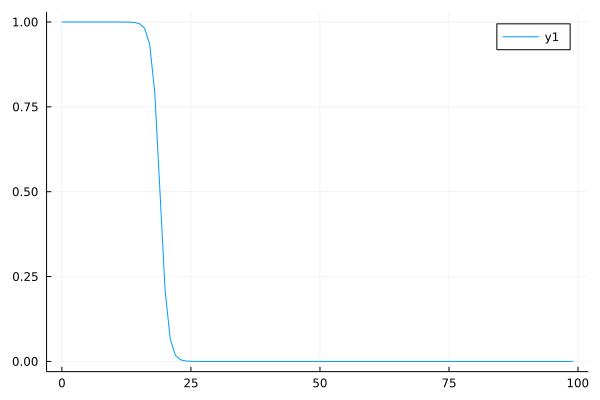

In [14]:
x = 0:Δx:Δx*(ngrid-1) |> collect
plot(x,ϕ[:,1])

In [15]:
position(ϕ,Δx,mgrid)

20.00000000000356

For `DifferentialEquations.jl` to do its work, we need to give it the problem in the formulation:

$$ u_t = f(u) $$

Let's define that right hand side $f(u)$ based on our phase field formulation:

In [16]:
function f(dϕ, ϕ, p, t)
    neumann!(ϕ)
    step!(dϕ,ϕ,p)
end

f (generic function with 1 method)

We formulate the semi-discretized system as an `ODEProblem` which is an abstraction that `DifferentialEquations.jl` provides. We pass our RHS, the initial condition $\varphi_0$, the time span of interest and the model parameters.

In [17]:
tspan = (0,100)
prob = ODEProblem(f, ϕ, tspan, p)

ODEProblem with uType Matrix{Float64} and tType Int64. In-place: true
timespan: (0, 100)
u0: 100×3 Matrix{Float64}:
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 0.999998  0.999998  0.999998
 ⋮                   
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0

To solve the system in time, we employ a Chebyshev method, more specifically the stabilized fourth order Runge-Kutta method, which is implemented in the function `ROCK4()`.

In [18]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999999999900488 0.9999999999900488 0.9999999999900488; 0.9999999999622486 0.9999999999622486 0.9999999999622486; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.0000000126318254 1.0000000126318254 1.0000000126318254; 1.0000000126318254 1.0000000090960126 1.0000000126318254; … ; -3.6587467043825405e-44 -2.235219028855345e-43 -3.6587467043825405e-44; -3.6587467043825405e-44 -3.6587467043825405e-44 -3.6587467043825405e-44]
 [1.0000001891968238 1.0000001891968238 1.0000001891968238; 1.0000001891968238 1.0000002367818075 1.0000001891968238; … ; 1.3971985337870962e-31 3.128104533327074e-31 1.3971985337870962e-31; 1.3971985337870962e-31 1.3971985337870962e-31 1.3971985337870962e-31]
 [1.0000005125359628 1.0000005125359628 1.0000005125359628; 1.0000005125359628 1.0000005393777678 1.0000005125359628; … ; -8.427

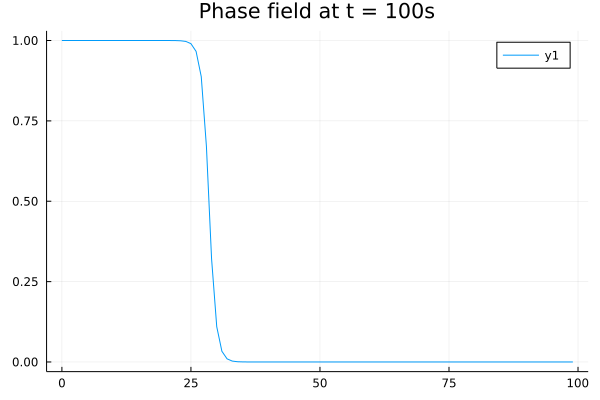

In [19]:
plot(x,sol[end][:,1], title = "Phase field at t = $(tspan[end])s")

`eachindex` is a function that conveniently outputs a range that automatically includes all elements of an array. This is especially useful when operating on multidimensional arrays, as this function then automatically visits each index in a memory-friendly fashion (i.e. along the strides).

In [20]:
positions = zeros(length(sol))
@inbounds for i ∈ eachindex(sol)
    positions[i] = position(sol[i],Δx,mgrid)
end

In [21]:
t = range(tspan[1], tspan[end], length = 500) |> collect
position_theory = positions[1] .+ M / Γ * μ₀ .* t;

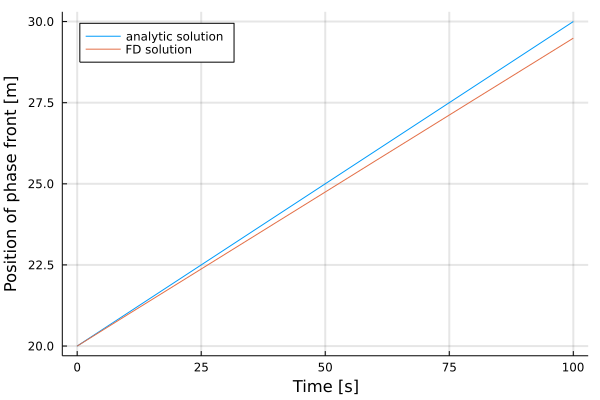

In [22]:
plot(t, position_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Position of phase front [m]", legend = :topleft)
plot!(sol.t, positions, label = "FD solution", grids = :all, gridlinewidth = 2.0)

Just for fun, let's see how resource usage is for solving our semi-discretized problem. Just like above, we simply need to use one additional macro:

In [23]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 2651 samples with 1 evaluation.
 Range (min … max):  1.661 ms …   6.568 ms  ┊ GC (min … max): 0.00% … 64.91%
 Time  (median):     1.694 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.881 ms ± 766.726 μs  ┊ GC (mean ± σ):  7.39% ± 12.25%

  █▅▃▁  ▁                                                      
  ████▇▇██▇▅▁▁▁▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▃▅▅▇▆▇▇▇ █
  1.66 ms      Histogram: log(frequency) by time      5.78 ms <

 Memory estimate: 3.19 MiB, allocs estimate: 6311.

As expected, this doesn't take long at all - not bad. However, we need to keep in mind that Julia is a just-in-time compiled language. That means that the first execution of the program takes considerably longer because compile time is included. What we see here are the timings of subsequent executions. So especially for simulations, take that number with a grain of salt.

# Vanishing grain problem

Next, we investigate an unstable circular grain that is located in the center of a rectangular domain. In order so save some time, we only look at a quarter slice of the original domain.

In [24]:
mgrid = 52
ngrid = 50
# Grid spacing [m]
Δx = 1.0

# Radius of the nucleus
r = 20.0
# Location of the nucleus center
r₀ = (0.0, 0.0)


(0.0, 0.0)

In [25]:
tspan = (0.,100.)

(0.0, 100.0)

In [26]:
# Model parameters
Γ   = 50.0                 # [J/m^2] interface energy
ξ   = 4.0                  # [m] phasefield interface width
M   = 1.0                  # [m^2/s] kinetic coefficient
μ₀  = 0.0                  # [J/m^3] bulk energy density difference (driving force)

# Params vector
p = vcat(Γ,ξ,M,μ₀,Δx);

The initial condition reads:

$$
u(r,t=0) = \frac{1}{2}\left(1 - \mathrm{tanh}\frac{r-R_0}{\xi}\right)
$$

Where $R_0$ is the radius of the nucleus and $\xi = 2a$ is the interface width.

In [27]:
function circular_nucleus(x,y,center,ξ,r)
    dist_to_center = sqrt((x - center[1])^2+(y - center[2])^2)
    return 0.5*(1.0 - tanh((dist_to_center - r)/ξ))
end
#= Mutating function that imposes the initial condition on a field φ
Args:
    φ: AbstractMatrix{Float}
    ξ: Number
    r: Number
    r₀: Tuple
Returns:
    φ
=#
function initial!(ϕ, ξ, r, r₀, Δx)
    @inbounds for i ∈ 1:size(ϕ,1)
        @inbounds for j ∈ 1:size(ϕ,2)
            @views ϕ[i,j] = circular_nucleus(i*Δx,j*Δx,r₀,ξ,r)
        end
    end
end

initial! (generic function with 1 method)

In [28]:
ϕ₀ = zeros(ngrid,mgrid)
initial!(ϕ₀,ξ,r,r₀,Δx)

In [29]:
xs = range(0,Δx*mgrid, length=mgrid) |> collect
ys = range(0,Δx*ngrid, length=ngrid) |> collect
x_grid = [x for x = xs for y = ys]
y_grid = [y for x = xs for y = ys];

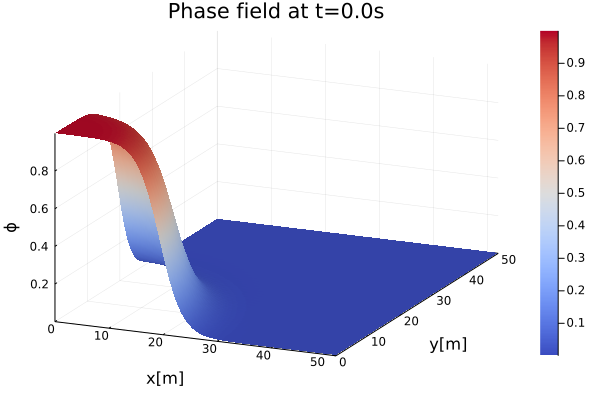

In [30]:
plot(x_grid, y_grid, reshape(ϕ₀,:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[1])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

Again, we assemble the ODE problem using our ODE function `f`, the IC $\phi_0$, the time span and the model parameters.

In [31]:
prob = ODEProblem(f, ϕ₀, tspan, p);

For convenience and sake of comparability, we use identical settings for the solver, i.e. we employ the RK4 algorithm once again:

In [32]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999079321995433 0.9998611484071415 … 1.846319090947901e-7 1.1199547594875625e-7; 0.9998611484071415 0.9998132935875019 … 1.8193788625664453e-7 1.1039248537514368e-7; … ; 5.01781028061643e-7 4.941631235322319e-7 … 9.665990230445232e-12 6.728673174194455e-12; 3.043766858001895e-7 2.998473556670156e-7 … 6.823541731648675e-12 4.766631533925647e-12]
 [0.9992299622796517 0.9992299622796517 … 2.8697820624182436e-7 2.8697820624182436e-7; 0.9992299622796517 0.999266892666072 … 2.5864772040948277e-7 2.8697820624182436e-7; … ; 7.740572779887185e-7 6.971064287117949e-7 … 2.3979319104397e-11 2.6114657060620756e-11; 7.740572779887185e-7 7.740572779887185e-7 … 2.6114657060620756e-11 2.6114657060620756e-11]
 [0.9988783752819345 0.9988783752819345 … 2.697325956409048e-7 2.697325956409048e-7; 0.99887837528

Notice how the solution time only marginally differs from our (pseudo) 1D problem, although the grid is much larger!

Let's visualize the last time step of the solution, which we can access just like an array, although the underlying struct holds a lot more information.

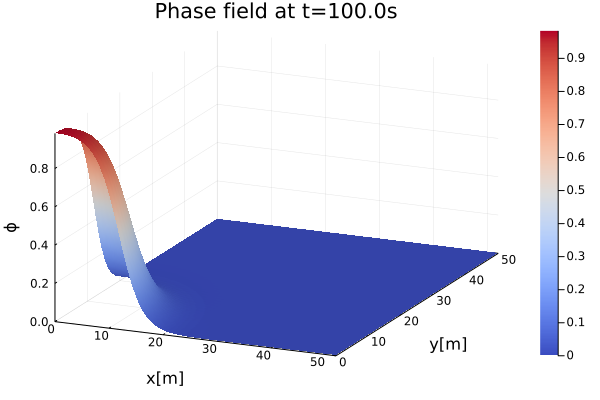

In [33]:
plot(x_grid, y_grid, reshape(sol[end],:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[end])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

Now, let's compare that against an analytical solution. The temporal evolution of the radius is given by:

$$
R(t)=\sqrt{R_{0}^{2}-2K\Gamma t}
$$

In [34]:
radius_model = zeros(length(sol))
for i ∈ eachindex(sol)
    radius_model[i] = sqrt(4.0 * integral(sol[i],Δx) / π)
end
radius_model
radius_theory = sqrt.(max.(0.0,(radius_model[1]^2 .- 2.0 * M .* t)));

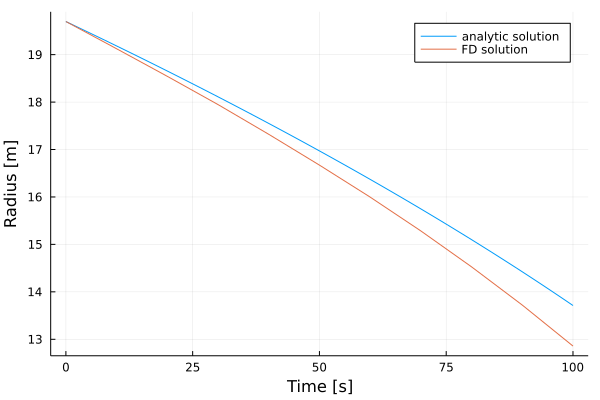

In [35]:
plot(t, radius_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Radius [m]", legend = :topright)
plot!(sol.t, radius_model, label = "FD solution")

In [36]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 532 samples with 1 evaluation.
 Range (min … max):  9.195 ms …  12.293 ms  ┊ GC (min … max): 0.00% … 21.56%
 Time  (median):     9.242 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.398 ms ± 536.282 μs  ┊ GC (mean ± σ):  1.21% ±  4.37%

  █▆▅▃                                                         
  █████▇▇▅▆▇▅▆▄▁▄▁▄▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▆▆▄ ▇
  9.2 ms       Histogram: log(frequency) by time      11.8 ms <

 Memory estimate: 4.00 MiB, allocs estimate: 4708.

Notice how execution time did not go up linearly with the problem size: For the 1D Problem we had 100 x 3 = 300 grid points, whereas for the 2D simulation we had 52x50 = 2.600 points. Following this calculation, we would expect an increase in execution time larger than the approximate 5x we have seen. It is also notable that the number of allocations stayed approximately constant.

# Some more optimizations

We can employ some additional measures to make our code more performant and especially more suitable for running it on architectures other than the CPU.

One key component is re-writing the loops using stencils in matrix form. As we are dealing with a discretized system, the usually infinite-dimensional laplacian operator can be expressed as a finite-dimensional operator in matrix form.

The (element-wise) laplacian in central difference form reads:

$$ \Delta u \approx \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \cdot \begin{bmatrix} u_{-1} \\ u_0 \\ u_1 \end{bmatrix} $$

Now, if we want to go to town and do this along a vector of $u$ values, the derivative needs to become a matrix. In this case we obtain a tridiagonal matrix with $[1,-2,1]$ is the central band.

$$ D = \frac{1}{\Delta x^2} \begin{bmatrix}
-2 & 1 &  &  &  &  \\
1 & -2 & 1 &  &  &  \\
 & 1 & -2 & 1 &  &  \\
 &  & 1 & \ddots &  &  \\
 &  &  &  & \ddots & 1 \\
 &  &  &  & 1 & -2 
\end{bmatrix} $$

If we multiply this on our 2D field $\phi$ with $D \cdot \Phi$ with $\Phi$ being the field matrix, we perform diffusion along the y-direction of the field since that is the dimension we preserve in this matrix multiplication.

That leaves the x-direction to operate on. Similarly, we can take care of this by multiplying $\Phi$ with the same stencil from the right side, so that the laplacian in 2D becomes:

$$ \Delta \Phi \approx D_y \Phi + \Phi D_x $$

Lets Code that. It is useful to the compiler to know about arrays that won't change in size, because by default they are mutable in size (in contrast to tuples). We can annotate them using `const` to restrict this and give the compiler more freedom for optimization. Our laplacian arrays fulfill that criterion.

In [37]:
using LinearAlgebra
const Mx = 1/Δx^2 * Tridiagonal([1.0 for i ∈ 1:mgrid-1], [-2.0 for i ∈ 1:mgrid], [1.0 for i ∈ 1:mgrid-1])
const My = 1/Δx^2 * Tridiagonal([1.0 for i ∈ 1:ngrid-1], [-2.0 for i ∈ 1:ngrid], [1.0 for i ∈ 1:ngrid-1])

50×50 Tridiagonal{Float64, Vector{Float64}}:
 -2.0   1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  1.0  -2.0   1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅    1.0  -2.0   1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅    1.0  -2.0   1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅    1.0  -2.0   1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅    1.0  -2.0  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅    1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋮                             ⋮    ⋱         ⋮                      
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅    

We can even incorporate the Neumann BC in a smart way into this stencil.

We wish to eliminate the flux of the field at the boundaries, i.e. for a 1D stencil at the left and right side of the domain. First, we imagine another "virtual" element left of the leftmost element $u_0$. So the laplacian at the leftmost element $u_1$ becomes:

$$ \Delta u_1 \approx \frac{u_0 - 2 u_1 + u_2}{\Delta x^2} $$

Now, if we want the flux to vanish, we should set $u_0$ equal to $u_2$, as the second derivative then becomes zero. By doing this we get:

$$ \Delta u_1 \approx \frac{- 2 u_1 + 2 u_2}{\Delta x^2} $$

The treatment of the other boundary is analogous as well as manipulating the stencil for the other direction. However for `My` we need to do this in a flipped way as the concatenation in the matrix product there is row-wise and not column-wise.

In [38]:
Mx[2,1] = 1/Δx^2 * 2.0
Mx[end-1,end] = 1/Δx^2 * 2.0
My[1,2] = 1/Δx^2 * 2.0
My[end,end-1] = 1/Δx^2 * 2.0;

Now, why is this so important?

One of the most powerful features in Julia is called multiple dispatch. That means you can have multiple definitions of one function that do different things depending of the types of their arguments. For example, that's how the simple addition operator `+` is impelemented efficiently in Julia. There's just hundreds of definitions for about any combination of data types imaginable, `Int + Int`, `Float64 + Float64`, `BigInt + BigInt` and so on.

How does this help us here? It turns out that the hardware-specialized libraries such as `CUDA.jl` implement their functions simply by overloading the usual functions with definitions for the hardware-specific types (such as `CuArray`).

Multiple dispatch is one reason. The other is that visiting each element in an array like we did in the implementation above is just so ineffective to do on GPUs that it bogs down the entire program. That's why in `CUDA.jl` an error will be thrown when this so-called scalar indexing is detected. However, general matrix multiplication (or GEMM) is blazing fast - and it doesn't hurt performance on the CPU, so it just makes sense to rewrite it this way.

For the source terms, there's not much left to do actually, since we can easily broadcast the scalar functions element-wise over the entire array using the broadcast function / the dot-operator - which in Julia really is just syntactic sugar. That means, calling `dg.(ϕ)` is just another way of calling `broadcast(dg, ϕ)`. So we leave `dg` and `dh` as they are.

Broadcasting is also a thing that GPUs like in Julia since the vectorized operations are abstracted away in the libraries, so if we can express our function this way, we actually need not worry.

We can now re-write the right hand side of the ODE given our new stencil:

In [39]:
function f(dϕ, ϕ, p, t)
    dϕ = p[3] * ( (My * ϕ + ϕ * Mx)  - 2.0/p[2]^2 * dg.(ϕ) + p[4]/(3.0*p[1]*p[2]) * dh.(ϕ) )
end

f (generic function with 1 method)

Note that by incorporating the Neumann BC into the stencil directly, we have gotten rid of the Neumann update step entirely.

So what else can we do? In general, it's a good idea to avoid allocations as discussed earlier. To see what's going on under the hood, we can use another macro that Julia itself provides: `@code_lowered`

In [40]:
@code_lowered My * ϕ

CodeInfo(
1 ─ %1 = LinearAlgebra.eltype(A)
│   %2 = LinearAlgebra.eltype(B)
│        TS = LinearAlgebra.promote_op(LinearAlgebra.matprod, %1, %2)
│   %4 = TS
│   %5 = LinearAlgebra.size(A, 1)
│   %6 = LinearAlgebra.size(B, 2)
│   %7 = Core.tuple(%5, %6)
│   %8 = LinearAlgebra.similar(B, %4, %7)
│   %9 = LinearAlgebra.mul!(%8, A, B)
└──      return %9
)

What this macro does is that it outputs the function sequence that our input is converted to. Or in other words we can see what an overloaded function does in the background. In this case we called `*` on two Array types and want to see what's going on.

From the output we see two things:
1. Julia calls the mutating function `mul!` on the inputs. That is a function implemented in the `LinearAlgebra` package which interfaces to OpenBLAS by default.
2. As a first argument to `mul!`, a temporarily allocated array is passed that has the dimensions of the output and is generated by the `similar` function.

Now in this case, it might be worthwile to pre-allocate this array since we have to do this multiplication a lot of times and it would be inefficient to create and destroy the array all the time.

In [41]:
const My_ϕ = zeros(ngrid, mgrid)
const ϕ_Mx = zeros(ngrid,mgrid)

50×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     

Let's look at the output now when we call `mul!` directly:

In [42]:
@code_lowered mul!(My_ϕ,My,ϕ)

CodeInfo(
1 ─      nothing
│   %2 = LinearAlgebra.mul!(C, A, B, true, false)
└──      return %2
)

We can see that the allocation along with all the necessary type inference is gone, so we managed to do exactly what we wanted - not bothering the compiler with stuff we already know in practice.

So what did that get us performance-wise?

In [43]:
ϕ = randn(ngrid,mgrid);

In [44]:
@benchmark $My * $ϕ + $ϕ * $Mx

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  135.873 μs …  2.898 ms  ┊ GC (min … max): 0.00% … 91.88%
 Time  (median):     150.930 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   155.903 μs ± 86.667 μs  ┊ GC (mean ± σ):  2.35% ±  3.95%

                         ▂█▇▃                                   
  ▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅█████▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  136 μs          Histogram: frequency by time          171 μs <

 Memory estimate: 169.41 KiB, allocs estimate: 21.

In [45]:
@benchmark mul!($My_ϕ,$My,$ϕ) + mul!($ϕ_Mx,$ϕ,$Mx)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.701 μs … 356.113 μs  ┊ GC (min … max): 0.00% … 97.05%
 Time  (median):     5.284 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.686 μs ±  10.554 μs  ┊ GC (mean ± σ):  7.06% ±  3.75%

   ▂▃▃▂▁             ▁▂▃▅▆▇███▇▆▅▄▃▂▂▁▁                       ▃
  ██████████▇▇███▇▇▇████████████████████▇▇▅▅▃▅▅▆▄▆▅▆▆▇▄▃▆▄▅▄▃ █
  4.7 μs       Histogram: log(frequency) by time      6.01 μs <

 Memory estimate: 20.36 KiB, allocs estimate: 2.

We came down from an average execution time of 185.6 µs to 8.4 µs and almost eliminated all allocations (the remainder is likely due to the addition). Not bad at all.

Now let's update our right hand side once again. This time, we will call `mul!` with our new pre-allocated arrays by ourselves and leave the rest as it was.
When modeling the equation itself, we use the broadcast macro `@.` which again is basically just syntactic sugar. It automatically broadcasts all function calls within the expression that follows the macro. In this case those are simply `dg` and `dh`.

In [46]:
function f(dϕ,ϕ,p,t)
    mul!(My_ϕ,My,ϕ)
    mul!(ϕ_Mx,ϕ,Mx)
    @. dϕ = p[3] * ( My_ϕ + ϕ_Mx - 2.0/p[2]^2 * dg(ϕ) + p[4]/(3.0*p[1]*p[2]) * dh(ϕ) )
end

f (generic function with 1 method)

In [47]:
prob = ODEProblem(f, ϕ₀, tspan, p);

In [48]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999079321995433 0.9998611484071415 … 1.846319090947901e-7 1.1199547594875625e-7; 0.9998611484071415 0.9998132935875019 … 1.8193788625664453e-7 1.1039248537514368e-7; … ; 5.01781028061643e-7 4.941631235322319e-7 … 9.665990230445232e-12 6.728673174194455e-12; 3.043766858001895e-7 2.998473556670156e-7 … 6.823541731648675e-12 4.766631533925647e-12]
 [0.9994909509338633 0.9994526532020682 … 2.2687449495229017e-7 2.011523675572589e-7; 0.9994526532020682 0.9994128741497662 … 2.2559775525956276e-7 2.000300422947586e-7; … ; 6.123104525890698e-7 6.087294477013083e-7 … 1.8493979217914472e-11 1.7305828944702855e-11; 5.42977048945444e-7 5.398296531372177e-7 … 1.738573932231144e-11 1.627462500279022e-11]
 [0.9992587344393621 0.9992078513341615 … 2.0291655890862135e-7 1.807277400718927e-7; 0.99920785133

In [49]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 682 samples with 1 evaluation.
 Range (min … max):  7.184 ms …  10.419 ms  ┊ GC (min … max): 0.00% … 28.97%
 Time  (median):     7.225 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.330 ms ± 501.089 μs  ┊ GC (mean ± σ):  1.13% ±  4.76%

  █▅▅▂                                                         
  █████▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█ ▇
  7.18 ms      Histogram: log(frequency) by time      10.3 ms <

 Memory estimate: 2.55 MiB, allocs estimate: 3024.

In [50]:
@benchmark sol = solve($prob, saveat = 10.0, alg_hints=[:stiff]; jac=true, sparse=true)

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

Excessive output truncated after 525405 bytes.

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

BenchmarkTools.Trial: 470 samples with 1 evaluation.
 Range (min … max):  10.439 ms …  20.739 ms  ┊ GC (min … max): 0.00% … 29.44%
 Time  (median):     10.526 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.637 ms ± 677.153 μs  ┊ GC (mean ± σ):  0.24% ±  1.94%

   ▄█▇▆▅▃▄▄▄▄▄▃▁▁▂ ▁                                            
  ██████████████████▆▆▆▄▄▆▇▄▄▁▁▁▁▆▄▄▁▁▄▁▄▄▁▄▁▄▁▄▆▆▆█▁▆▆▄▁▄▄▁▄▆ ▇
  10.4 ms       Histogram: log(frequency) by time      11.3 ms <

 Memory estimate: 391.67 KiB, allocs estimate: 2314.

As we can see, compared to our previous implementation, we didn't gain an awful lot - but keep in mind that this is a single-threaded application. As soon as we get to many workers doing the computations in parallel, this effort will pay off.

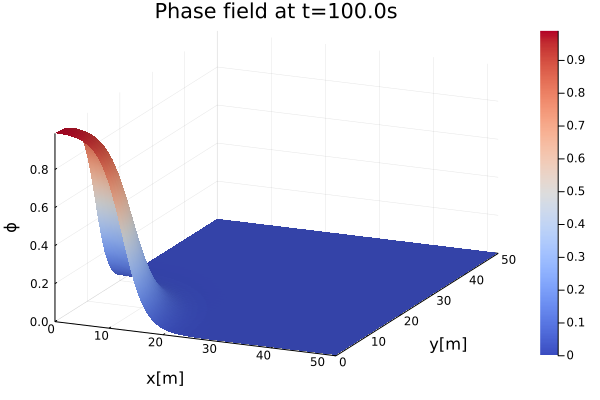

In [51]:
plot(x_grid, y_grid, reshape(sol[end],:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[end])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

In [52]:
radius_model = zeros(length(sol))
for i ∈ eachindex(sol)
    radius_model[i] = sqrt(4.0 * integral(sol[i],Δx) / π)
end
radius_model
radius_theory = sqrt.(max.(0.0,(radius_model[1]^2 .- 2.0 * M .* t)));

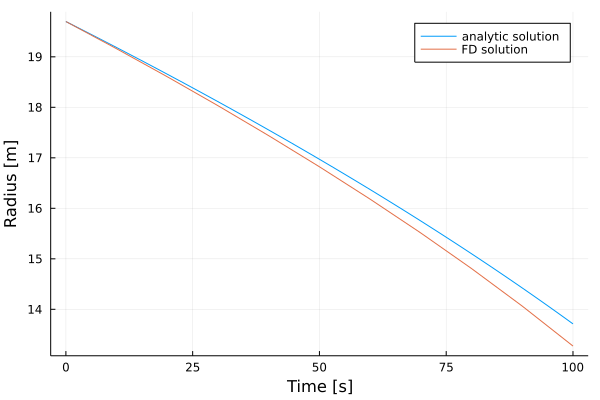

In [53]:
plot(t, radius_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Radius [m]", legend = :topright)
plot!(sol.t, radius_model, label = "FD solution")

# Switching over to Automatic Differentiation

If we want to employ deep learning, where a lot of derivatives are required during training, it is worthwile to ask how to get to those derivatives. One method particularly suited to ML is called automatic differentiation.

It is principally different from purely numeric approaches like Finite Difference where we take a finite-dimensional approximation of the derivative operator (in this case we simply take the first few elements of the Taylor expansion).
In contrast, the basic idea of AD is that every function (especially in computer-friendly form) is just a combination of a few primitive functions, where the derivative is well-known analytically. That means that in essence, AD is all about repeatedly applying the chain rule of differentiation to the function in question.

In principle, we have the choice between forward mode AD and reverse mode AD. The question of which one to choose really comes down to how many input and output parameters the functions we wish to differentiate have.

If we have considerably more inputs than outputs, forward mode is the way to go. If it's the other way round, reverse mode is more feasible. Otherwise, the choice of algorithm doesn't matter too much.

A good rule of thumb is that reverse mode outperforms forward mode in deep learning, so that's what we'll go for. The most popular Julia library for that is `Zygote.jl`

In [54]:
using Zygote

Let's set up a very simple function to toy around with first. We define a scalar function that takes two arguments $x$ and $y$:

$$ f(x,y) = 3x^2 - 5y $$

One additional thing we'll incorporate though is that we instruct julia to perform the operations element-wise, so that we can also take in vectors.

In [55]:
f(x,y) = 3 .* x.^2 - 5 .* y
f(rand(10),rand(10))

10-element Vector{Float64}:
  0.26934531518864
 -1.5236877357039815
 -2.0585690160034114
 -2.1827532730367607
 -1.94912123441223
 -1.4334216394437982
  1.7495922293596373
 -0.7207745267214558
  0.46324850553302954
  2.3363090125968484

Now, let's evaluate the gradient of this function at the point $x=1$, $y=2$. This will return a vector of two elements, since we have a function of two variables. Let's only query the x-component, i.e. the first element of the vector:

In [56]:
gradient(f, 1, 2)[1]

6.0

AD in general is nearly exact in its computation up to machine precision. Let's double check the result. Writing up the partial derivative w.r.t $x$ is simple enough:

$$ \frac{\partial f}{\partial x} = 6x $$

Plugging in $x=1$ exactly yields the ouptut value.

For this function, it is very easy for us and Zygote to unpack this function into simple primitives. We have one difference operator, which we can simply call the derivative on element-wise.

The next step is to look at the terms $3x^2$ and $5y$ separately. Here, we encounter a product each: $3 \cdot x^2$ and $5 \cdot y$. As both arguments are scalars each, there's no need to apply the chain rule here which means `Zygote` is done with the second part as we have now arrived at the primitive function $y$. For $x^2$, there is one more step to do, i.e. applying the chain rule:

$$ \frac{\partial^2}{\partial x^2} (u(x))^2 = 2 \cdot u(x) \cdot u'(x) $$

But since $u'(x) = 1$, we're done now.

By the way, we could have shortened this example by directly passing an anonymous function (i.e. a function without being explicitly stored in memory) to the `gradient` function:

In [57]:
gradient(f, 1, 2) == gradient((x,y) -> 3 .* x.^2 - 5 .* y, 1, 2)

true

But we're not done. Zygote can also compute the Hessian matrix, i.e. the matrix of second derivatives. However, now we need to pass our arguments as one vector. That means we have to wrap our scalar function `f` into another anonymous function that unpacks the vector into its components:

In [58]:
hessian(x -> f(x[1],x[2]), [1,2])

2×2 Matrix{Int64}:
 6  0
 0  0

If we don't care about mixed derivatives, i.e. the off-diagonal elements of the hessian, we can use `diaghessian` instead:

In [59]:
diaghessian(x -> f(x[1],x[2]), [1,2])

([6, 0],)

In [60]:
diaghessian(x -> f(x[1],x[2]), [1,2])[1] |> sum

6

# Putting a Neural Network to work

With our high-order time discretization, the main source of error now is the spatial Finite Difference discretization. This begs the question whether we could do better on that.

First of all, we could use a higher order stencil which would increase computational cost and accuracy. A second option would be to use another family of methods. Since the Allen-Cahn problem is a semilinear parabolic PDE, spectral methods would be well suited for the problem and have shown to provide exponential convergence on these types of problem, which is excellent.

However, we wish to explore an entirely different route, namely Physics Informed Machine Learning. A continuous time approach has shown to be very expensive. Also, this approach is not optimal in the sense that time is treated as an unrestricted dimension, i.e. all timesteps are solved for at once and even negative times would be allowed in theory. That means that the sequentiality is not really accounted for and therefore e.g. in hyperbolic problems the satisfaction of entropy conditions can be difficult.

Now, solving ODEs numerically (in contrast to PDE research) can be considered a very mature field with over 100 years of intensive research and hence there is a plethora of algorithms available to tacke various tasks, among others also stiff problems that very often arise in PDEs. So naturally, these capabilities lend themselves to remedy this shortcoming of PINNs. This means that we ideally still leave the ODE solve of the semi-discretized system to a classical method, whereas the solution of the spatially defined problem can be put off to a PINN.

We could in theory model the entire right-hand side of the semi-discrete system. Though, the only part containing spatial derivatives is the laplacian. Therefore, we will leave the polynomial terms as-is.

The following PINN code is largely stolen from the [`NeuralPDE.jl` docs](https://neuralpde.sciml.ai/stable/pinn/2D/)

In [61]:
using NeuralPDE, Flux, ModelingToolkit, GalacticOptim, Optim, DiffEqFlux
using Quadrature, Cuba, CUDA, QuasiMonteCarlo
import ModelingToolkit: Interval, infimum, supremum

First, we declare the inputs, outputs and derivatives symbolically. This can be done thanks to `ModelingToolkit.jl` which provides symbolic computing capabilities

In [62]:
@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2
# First derivatives are necessary for the Neumann BCs
Dx = Differential(x)^2
Dy = Differential(y)^2

Differential(y) ∘ Differential(y)

Next, we define the domain. From past experience, it has proven to be slightly beneficial to train the functional mapping in unit domains for more robust convergence. Hence we normalize the 2D domain to the unit intervals.

In [63]:
x_min = 0.
x_max = 1.
y_min = 0.
y_max = 1.

1.0

We only want to train the solution to the Laplace operator $ \nabla \nabla u = 0 $. Hence, the equation part is rather simple. The syntax is here given symbolically, with the tilde `~` replacing the equals sign since its a reserved character:

In [64]:
eq  = Dxx(u(x,y)) + Dyy(u(x,y)) ~ 0

Differential(x)(Differential(x)(u(x, y))) + Differential(y)(Differential(y)(u(x, y))) ~ 0

As we train a steady state problem, we only do BCs. `NeuralPDE` expects an Array of symbolic equations.

In [65]:
bcs = [
        Dx(u(x_min,y)) ~ 0.,
        Dx(u(x_max,y)) ~ 0.,
        Dy(u(x,y_min)) ~ 0.,
        Dx(u(x,y_max)) ~ 0.,
]

4-element Vector{Equation}:
 Differential(x)(Differential(x)(u(0.0, y))) ~ 0.0
 Differential(x)(Differential(x)(u(1.0, y))) ~ 0.0
 Differential(y)(Differential(y)(u(x, 0.0))) ~ 0.0
 Differential(x)(Differential(x)(u(x, 1.0))) ~ 0.0

Now, assign the spatial domains to the problem:

In [66]:
domains = [x ∈ Interval(x_min,x_max),
           y ∈ Interval(y_min,y_max)]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0..1.0)
 Symbolics.VarDomainPairing(y, 0.0..1.0)

The Neural Network Architecture is specified using `Flux.jl` with a Chain of Dense layers. However, we will use a specialized version of those functions here that `DiffEqFlux.jl` exports, i.e. `FastChain` instead of `Chain` and `FastDense` instead of `Dense`. Those variants are optimized to work with small networks, i.e. in the order of tens or few hundreds of layers, as this is a typical setting within Scientific Machine Learning. As activation we choose the `tanh` function:

In [67]:
using NNlib
inner = 32
activation = tanh_fast
laplace = FastChain(FastDense(2,inner,activation),
                  FastDense(inner,inner,activation),
                  FastDense(inner,inner,activation),
                  FastDense(inner,inner,activation),
                  FastDense(inner,1))

(::FastChain{Tuple{FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(identity), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}}}) (generic function with 1 method)

GPU Training defaults to single precision. However, we want double precision, so we have to initialize the weights explicitly using `Float64`.

In [68]:
initθ = CuArray(Float64.(DiffEqFlux.initial_params(laplace)))

3297-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -0.3153640329837799
 -0.35558006167411804
 -0.21946558356285095
 -0.1258639395236969
  0.35467100143432617
 -0.3760811984539032
  0.25301337242126465
  0.05256829410791397
 -0.0817919671535492
  0.2958303391933441
  ⋮
  0.39127492904663086
  0.3783794045448303
 -0.23547221720218658
 -0.15039128065109253
 -0.3158469796180725
  0.3807156980037689
  0.19447772204875946
  0.20143313705921173
  0.0

Next we specify the training strategy. We use grid training with a residual point spacing of 0.02 and create the PINN type that NeuralPDE expects.

In [69]:
strategy = GridTraining(0.02)
discretization = PhysicsInformedNN(laplace,
                                   strategy;
                                   init_params = initθ)

PhysicsInformedNN{true, FastChain{Tuple{FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(identity), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}}}, GridTraining, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, NeuralPDE.var"#280#282"{FastChain{Tuple{FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(tanh_fast), DiffEqFlux.var"#initial_params#94"{Vector{Float32}}, Nothing}, FastDense{typeof(identity), DiffE

We can now assemble the full system. Finally, we transfer the symbolically defined problem into a numeric form that training can happen on using `discretize`.

In [70]:
@named pde_system = PDESystem(eq,bcs,domains,[x,y],[u(x, y)])
prob = discretize(pde_system,discretization)
symprob = symbolic_discretize(pde_system,discretization)

(Expr[:((cord, var"##θ#292", phi, derivative, integral, u, p)->begin
          #= /home/zimbropa/.julia/packages/NeuralPDE/SsHLm/src/pinns_pde_solve.jl:600 =#
          #= /home/zimbropa/.julia/packages/NeuralPDE/SsHLm/src/pinns_pde_solve.jl:600 =#
          begin
              let (x, y) = (cord[[1], :], cord[[2], :])
                  begin
                      cord1 = vcat(x, y)
                  end
                  (+).(derivative(phi, u, cord1, [[6.0554544523933395e-6, 0.0], [6.0554544523933395e-6, 0.0]], 2, var"##θ#292"), derivative(phi, u, cord1, [[0.0, 6.0554544523933395e-6], [0.0, 6.0554544523933395e-6]], 2, var"##θ#292")) .- 0
              end
          end
      end)], Expr[:((cord, var"##θ#292", phi, derivative, integral, u, p)->begin
          #= /home/zimbropa/.julia/packages/NeuralPDE/SsHLm/src/pinns_pde_solve.jl:600 =#
          #= /home/zimbropa/.julia/packages/NeuralPDE/SsHLm/src/pinns_pde_solve.jl:600 =#
          begin
              let (x, y) = (cord[[1], :], c

The only things left now are to define a callback function to observe training and to call the actual optimizer. We use the classic BFGS Optimizer here, since this should be a simple enough problem to have a rather smooth and hence well-behaved solution manifold and BFGS delivers fast convergence.
We also give a stopping criterion for the optimization as soon as the residual dips below 1e-7.

In [71]:
Loss = []

cb = function (p,l)
    println("Current loss is: $l")
    push!(Loss,l)
    if l < 1e-7
        return true
    else
        return false
    end
end

#res = GalacticOptim.solve(prob,ADAM(0.001);cb=cb,maxiters=2500)
res = GalacticOptim.solve(prob,Optim.BFGS();cb=cb,maxiters=1000)

u: 3297-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -0.3092922254274045
 -0.3307569671386443
 -0.2190415493903384
 -0.12856919391248717
  0.35394763794890294
 -0.36240889270569254
  0.25954662023641795
  0.0416229440457612
 -0.08252505326574551
  0.29131020629992244
  ⋮
  0.3838999557217953
  0.3811651993888323
 -0.2409015547551612
 -0.14320703909260352
 -0.3066337318595221
  0.37950085563705327
  0.19510030150228624
  0.19393279658267326
  0.0

In [72]:
neural_laplacian = discretization.phi

#280 (generic function with 1 method)

Let's see what order of magnitude we are in with the inference pass. One thing to note when benchmarking GPU kernels is that we have to tell Julia to synchronize the timing with CUDA. Otherwise, we would only be measuring the time it takes to transfer the arrays over to the GPU.

In [73]:
@benchmark CUDA.@sync $neural_laplacian(cu(rand(2)), $res.minimizer)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  128.820 μs … 261.852 ms  ┊ GC (min … max): 0.00% … 22.04%
 Time  (median):     136.161 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   165.513 μs ±   2.618 ms  ┊ GC (mean ± σ):  3.49% ±  0.22%

         ▄▆▇█▆▇▇▆▄▆▃▂▁                                           
  ▁▁▂▂▃▅▇█████████████▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▃▄▅▆▆▇▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁ ▄
  129 μs           Histogram: frequency by time          157 μs <

 Memory estimate: 29.41 KiB, allocs estimate: 619.

In [74]:
@benchmark CUDA.@sync $neural_laplacian(cu(rand(2,1000)), $res.minimizer)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  169.423 μs … 162.624 ms  ┊ GC (min … max): 0.00% … 27.37%
 Time  (median):     177.931 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   228.607 μs ±   2.743 ms  ┊ GC (mean ± σ):  5.49% ±  0.46%

       ▂▅█▇▄                                                     
  ▁▁▂▃▆██████▇▆▇▇█▇▇▇▅▆▄▄▃▃▂▂▂▂▂▂▃▄▅▆▆▄▄▃▂▂▂▂▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁ ▃
  169 μs           Histogram: frequency by time          204 μs <

 Memory estimate: 55.14 KiB, allocs estimate: 699.

Here, we observe the full capabilities of Machine Learning in combination with parallel architectures: It makes next to no difference whether we predict the steady-state laplacian for one 2D point or for 1000 different points at once.

# Assembling an actual Neural ODE

We can now turn over to re-formulating our semi-discretized ODE problem in terms of our new "laplacian".

To do this, we simply need to re-define the `f` function (the right-hand side of the semi-discretization) from before so that it uses our neural network to infer the updated phase field.

# Approximating a Laplacian with a CNN

Can we train the parameters of a CNN (i.e. the convolution filter) such that it produces a high order laplacian operator?


## Data Generation

In [75]:
grid = collect(0:0.01:1) * collect(0:0.01:1)' |> gpu

101×101 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0     0.0     0.0     0.0     0.0     …  0.0     0.0     0.0     0.0
 0.0  0.0001  0.0002  0.0003  0.0004  0.0005     0.0097  0.0098  0.0099  0.01
 0.0  0.0002  0.0004  0.0006  0.0008  0.001      0.0194  0.0196  0.0198  0.02
 0.0  0.0003  0.0006  0.0009  0.0012  0.0015     0.0291  0.0294  0.0297  0.03
 0.0  0.0004  0.0008  0.0012  0.0016  0.002      0.0388  0.0392  0.0396  0.04
 0.0  0.0005  0.001   0.0015  0.002   0.0025  …  0.0485  0.049   0.0495  0.05
 0.0  0.0006  0.0012  0.0018  0.0024  0.003      0.0582  0.0588  0.0594  0.06
 0.0  0.0007  0.0014  0.0021  0.0028  0.0035     0.0679  0.0686  0.0693  0.07
 0.0  0.0008  0.0016  0.0024  0.0032  0.004      0.0776  0.0784  0.0792  0.08
 0.0  0.0009  0.0018  0.0027  0.0036  0.0045     0.0873  0.0882  0.0891  0.09
 ⋮                                    ⋮       ⋱                          ⋮
 0.0  0.0092  0.0184  0.0276  0.0368  0.046      0.8924  0.9016  0.9108  0.92
 0.0  0.0093  0.

In [76]:
layer = Conv((5,5), 1 => 1, relu, pad=2) |> gpu

Conv((5, 5), 1 => 1, relu, pad=2)  # 26 parameters

In [77]:
phi = reshape(ϕ, (size(ϕ)...,1,1)) |> gpu

50×52×1×1 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}:
[:, :, 1, 1] =
 -0.252027    0.216964    0.0716191  …   0.694005     0.0646731  -0.614824
  1.51734    -0.835419    1.74257       -0.946879    -0.327421    0.644984
 -0.388266   -0.181994   -0.425414      -0.71054     -1.21055     1.02843
 -0.40486    -0.707629   -0.260817      -0.90229     -0.655111    1.25535
 -1.87807    -0.683136   -0.311333      -0.0870874    0.444892    0.854634
 -0.415868   -0.87934     0.832689   …  -1.50694      1.38587     0.228552
 -0.26437    -0.663755    0.882699       1.49551     -0.729462   -0.973744
 -1.48985    -0.30165     1.13307        1.2657      -0.749808    0.0960142
  1.34816     0.628449   -0.0510995     -0.510068     0.576895   -0.647578
 -0.921185   -0.287449    1.40255        0.0380363    2.08556     1.12747
  ⋮                                  ⋱                ⋮          
 -0.0563862   1.96791    -0.259301       0.380782     0.525866    1.45958
  0.2999     -0.0223687  -1.23577       -0.

In [78]:
layer(phi)

50×52×1×1 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}:
[:, :, 1, 1] =
 0.661084  0.0        0.0        0.0617839  …  0.172912  0.339587  0.0
 0.0       0.462526   0.0        0.0           1.26473   0.992104  0.0
 1.26694   0.529207   0.613834   0.0           0.0       0.0       0.0
 0.0       0.0989899  0.114506   0.0           1.25191   0.0       0.0
 0.196473  0.0        0.0        0.0           0.0       0.0       0.647539
 0.196352  1.06166    0.186356   0.0        …  0.0       0.0       0.608922
 0.0       0.0711741  0.0        0.687326      0.0       0.438817  1.23285
 0.224837  0.120823   0.0621451  0.42296       0.0       0.362375  0.0
 0.417915  0.0        0.693884   0.742419      1.33121   0.0       0.0
 0.0       0.0        0.0        0.244615      0.801481  0.0       0.308557
 ⋮                                          ⋱            ⋮         
 0.0       0.570699   0.743049   0.734947      0.0       1.08244   0.0
 0.0       0.184635   1.45756    0.137717      0.761536  0.0   

In [79]:
xrange = 0:0.01:1
yrange = 0:0.01:1

xgrid = collect(xrange)
ygrid = collect(yrange)'

1×101 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.01  0.02  0.03  0.04  0.05  …  0.95  0.96  0.97  0.98  0.99  1.0

Let's set up the polynomial functions now. A nice, recursive way to generate a polynomial out of the set of coefficients is known as Horner's method:

$$
b_n = a_n \\
b_{n-1} = a_{n-1} + b_n x \\
b_{n-2} = a_{n-2} + b_{n-1} x \\
... \\
b_0 = a_0 + b_1 x
$$

We can code this up in a function that contains this recursive loop. Note that we use the ellipsis operator `...`. This means that the function takes an arbitrary number of arguments that can each be addressed in the function body as elements of `a`. This is very convenient here because we want to create polynomials of arbitrary order.

In [80]:
function horner(x, a...)
    b = zero(x)
    for i = length(a):-1:1
        b = a[i] + b * x
    end
    return b
end

horner (generic function with 1 method)

Let's see how this runs. Here, we annotate the newly generated function with the type of the coefficients, because we have declared them as a global variable. By design, the compiler cannot infer the type of global variables as they can be changed by any other function, at any other time. Hence, we need to type them manually in order to enable code optimizations.

In [81]:
coeffs = rand(8)
f8(x) = horner(x,1,2,3,4,5,6,7,8)
@benchmark f8(0.2)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  1.104 ns … 4.074 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.110 ns             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.112 ns ± 0.052 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▅▇██▆▁                                                   
  ▃███████▇▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂ ▃
  1.1 ns         Histogram: frequency by time       1.16 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

We see no allocations and a reasonable runtime of around 10 ns for this task, nice.

But, we can do even better if we code our function generation routine as a macro. Macros are functions that generate expressions, which in turn get evaluated very early in the compilation process. Hence the compiler is able to perform many optimizations due to inlining and specialization.

The loop in our `horner` function would produce a nested function call due to the recursiveness of the algorithm. For combined multiplication and addition, Julia provides the `muladd` function to do these operations in one pass.

The help tells us that `muladd` takes three arguments `x`, `y`, `z` and outputs `x * y + z`.

So that would make our nested call look something like:

` muladd(x, 
    muladd(x,
        muladd(x,
            muladd(x,
            ...
            ,coeffs[4])
        ,coeffs[3])
    ,coeffs[2])    
,coeffs[1])
`
and so on. That means that the recursive part of the function call lies in the second argument.

To create a macro, we use the keyword `macro`.

One key difference to a function definition is that we now have to do some metaprogramming, i.e. we return an expression of type `Expr` that can be evaluated by the Julia compiler, and not the plain code itself like in a function.

Individual expressions are generated by wrapping the code into `:( ... )` brackets. To interpolate expressions into other expressions, we prefix them using `$` (like we did when calling the `@benchmark` macro).

The `Expr` type takes multiple arguments: a head of type `Symbol` that states the kind of expression (e.g. `:+` to express a summation of two arguments), and subsequently the arguments of that expression. In this case we form an expression of type `:block`

In [82]:
macro horner(x, p...)
    ex = esc(p[end])
    for i = length(p)-1:-1:1
        ex = :(muladd(t, $ex, $(esc(p[i]))))
    end
    Expr(:block, :(t = $(esc(x))), ex)
end

@horner (macro with 1 method)

In [83]:
f_macro(x) = @horner(x, 1,2,4,5,6,7,8)

f_macro (generic function with 1 method)

In [84]:
@macroexpand @horner(0.2, 1,2,3,4,5,6)

quote
    var"#824#t" = 0.2
    Main.muladd(var"#824#t", Main.muladd(var"#824#t", Main.muladd(var"#824#t", Main.muladd(var"#824#t", Main.muladd(var"#824#t", 6, 5), 4), 3), 2), 1)
end

In [85]:
@benchmark f_macro(0.2)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.014 ns … 0.028 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.016 ns             ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.016 ns ± 0.002 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃   █    █    ▄                                     ▂   ▁ ▂
  █▁▁▁█▁▁▁▁█▁▁▁▁█▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▅▁▁▁▁█▁▁▁█ █
  0.014 ns    Histogram: log(frequency) by time    0.026 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

Looks like this was rather fruitful, we achieved a speedup of about 10x.

So now let's make this a macro that produces bivariate polynomials:

In [86]:
macro gen_polys(x, y, p...)
    ex_x = esc(p[end])
    ex_y = esc(p[end])
    for i = length(p)/2-1:-1:1
        ex_x = :(muladd(t_x, $ex_x, $(esc(p[i]))))
        ex_y = :(muladd(t_y, $ex_y, $(esc(p[i+Int(length(p)/2)]))))
    end
    ex = :($ex_x + $ex_y)
    Expr(:block, :(t_x = $(esc(x))),:(t_y = $(esc(y))), ex)
end

@gen_polys (macro with 1 method)

In [87]:
polycoeffs = rand(20)
poly(x,y) = @gen_polys(x,y,1,2,3,4,5,6,7,8,9,10)

poly (generic function with 1 method)

In [88]:
@macroexpand @gen_polys(0.2,3.5,1,2,3,4,5,6,7,8,9,10)

quote
    var"#827#t_x" = 0.2
    var"#828#t_y" = 3.5
    Main.muladd(var"#827#t_x", Main.muladd(var"#827#t_x", Main.muladd(var"#827#t_x", Main.muladd(var"#827#t_x", 10, 4), 3), 2), 1) + Main.muladd(var"#828#t_y", Main.muladd(var"#828#t_y", Main.muladd(var"#828#t_y", Main.muladd(var"#828#t_y", 10, 9), 8), 7), 6)
end

In [89]:
poly(0.2,3.5)

2016.568

In [90]:
function poly_xy(x, y, a, b)
    c = zero(x)
    d = zero(y)
    for i = length(a):-1:1
        c = a[i] + c * x
        d = b[i] + d * y
    end
    return c + d
end

poly_xy (generic function with 1 method)

In [91]:
poly_xy(0.2,0.3,rand(5),rand(5))

1.6250441979497023

In [92]:
functions = Array{Function}
px = randn(1000,5) |> cpu
py = randn(1000,5) |> cpu

1000×5 Matrix{Float64}:
  0.24277    -1.69283   -0.776233  -0.0307412   1.15057
  1.33519     0.15162   -0.704538  -1.15563    -0.415939
  0.504661   -0.271794  -1.11101    0.213592   -3.26899
  0.849827    1.6383    -2.31345    0.429335    1.28421
  0.160614   -0.139364   0.274975  -0.490011   -1.54677
  0.219589   -1.68144    1.01286    1.06124     1.04213
  1.20775     1.66186    1.73141    0.277101    0.10412
  0.260097   -2.53873   -0.327249   0.906336   -0.304628
  0.560421   -0.422347   0.164545   0.794945   -0.513712
 -0.944244   -0.17393   -0.724733   0.0162217  -1.04113
  ⋮                                            
 -0.533477    0.309485   1.49611    0.49581    -0.475911
  0.0238308  -0.807718   1.65679   -0.519718   -0.99288
 -0.485613    0.436554   0.717499  -0.058176   -1.02483
  1.18577    -0.775694  -0.69875    0.214681    1.16445
 -0.361622   -0.958405  -0.746449   0.482824   -1.29204
  0.466902   -0.964748  -0.62303    0.167362   -2.01382
  1.3083      1.0172     0.5

In [93]:
function generate_functions(px, py)
    functions = Function[]
    for i ∈ 1:size(px,1)
        push!(functions, (x,y) -> poly_xy(x,y, px[i,:], py[i,:]))
    end
    return functions
end

generate_functions (generic function with 1 method)

In [94]:
functions = generate_functions(px, py);
@benchmark functions[300].(xgrid,ygrid)

BenchmarkTools.Trial: 4553 samples with 1 evaluation.
 Range (min … max):  599.656 μs … 23.312 ms  ┊ GC (min … max):  0.00% … 96.07%
 Time  (median):     967.946 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.096 ms ±  2.156 ms  ┊ GC (mean ± σ):  19.81% ±  9.61%

  ▇▄▂▃▂▁▁▂▃▂▁          █▇▆▆▃▂▁                                 ▂
  ███████████▇▆▄▆▅▄▅▆▄▅████████▇▆▃▄▁▃▃▅▄▅▁▇▆▄▅▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▃ █
  600 μs        Histogram: log(frequency) by time      1.63 ms <

 Memory estimate: 1.95 MiB, allocs estimate: 20406.

In [95]:
functions

1000-element Vector{Function}:
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 ⋮
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)
 #37 (generic function with 1 method)

In [96]:
function generate_grid(functions, xgrid, ygrid)
    data = zeros(length(xgrid),length(ygrid),length(functions))
    for i ∈ 1:length(functions)
        data[:,:,i] = functions[i].(xgrid,ygrid)
    end
    return data
end

generate_grid (generic function with 1 method)

In [97]:
data = generate_grid(functions,xgrid,ygrid);

In [98]:
size(data)

(101, 101, 1000)

Now we have a rather large array of input data, generated using our arbitrary coefficient, 5th order, bivariate polynomials. As we have the generating functions readily at hand, we can calculate the actual second derivatives to machine precision using AD.

For the loss function, we have to determine laplacians for $i$ functions on $j \cdot k$ grid points, resulting in $i \cdot j \cdot k$ evaluations.

These computations will be rather expensive and the total problem is embarassingly parallel, so let's put it off to the GPU.

In [99]:
# A second partial derivative w.r.t. the first spatial coordinate(x)
diaghessian(functions[1], xgrid[1],ygrid[1])[1]

-1.1787008386906908

In [100]:
# The Laplacian of the first generated function on the upper left corner of the domain
map(sum,diaghessian.((x,y) -> functions[1](x,y), xgrid,ygrid))

101×101 Matrix{Float64}:
  -2.73117   -2.73163   -2.72933   -2.72427  …  10.3481   10.6183   10.8912
  -2.72773   -2.72819   -2.7259    -2.72084     10.3515   10.6217   10.8946
  -2.7278    -2.72826   -2.72597   -2.72091     10.3515   10.6216   10.8945
  -2.73137   -2.73183   -2.72954   -2.72448     10.3479   10.6181   10.891
  -2.73844   -2.73891   -2.73661   -2.73155     10.3408   10.611    10.8839
  -2.74902   -2.74949   -2.74719   -2.74213  …  10.3303   10.6004   10.8733
  -2.7631    -2.76357   -2.76127   -2.75621     10.3162   10.5863   10.8592
  -2.78069   -2.78115   -2.77885   -2.77379     10.2986   10.5687   10.8416
  -2.80177   -2.80224   -2.79994   -2.79488     10.2775   10.5477   10.8206
  -2.82636   -2.82683   -2.82453   -2.81947     10.2529   10.5231   10.796
   ⋮                                         ⋱                       ⋮
 -17.0792   -17.0797   -17.0774   -17.0723      -3.99996  -3.72981  -3.4569
 -17.3981   -17.3986   -17.3963   -17.3912      -4.31882  -4.04867  -3

In [171]:
ytrain = similar(data);
BLAS.set_num_threads(18);
@inbounds @views for i ∈ 1:size(ytrain,3)
    ytrain[:,:,i] = map(sum,diaghessian.((x,y) -> functions[i](x,y), xgrid,ygrid))
end

In [ ]:
using BSON: @save

@save "train.bson" ytrain

In [102]:
using BSON: @load
@load "train.bson" ytrain

In [104]:
size(data) == size(ytrain)

true

## The model

We create a single convolutional layer with a fixed-size stencil, where the size of the convolution kernel (the stencil) is the hyper-parameter. There are existing works that address [the construction of high-order laplacian stencils](https://carretero.sdsu.edu/publications/postscript/2SHOC.pdf), but this quickly becomes a cumbersome tasks for high-order approximations.

So now we have to ask the question what size of kernel to use. Firstly, the kernel should be square as the Laplacian should be rotationally invariant, so it doesn't make sense to include more neighboring points in one spatial direction than the other.

Secondly, we can safely rule out a `(3,3)` kernel to be a viable candidate as it has been shown that a 9-point stencil *cannot* achieve higher than second order accuracy:

`@book{caplan2012study,
  title={Study of vortex ring dynamics in the nonlinear Schr{\"o}dinger equation utilizing GPU-accelerated high-order compact numerical integrators},
  author={Caplan, Ronald Meyer},
  year={2012},
  publisher={The Claremont Graduate University}
}`

That's why we start with a `(5,5)` kernel. Increasing the kernel size will result in increased computational cost, so we will work our way up from here.

In [105]:
using Flux

layer = Conv((5,5), 1 => 1, relu; pad = SamePad()) |> gpu

Conv((5, 5), 1 => 1, relu, pad=2)  # 26 parameters

The `SamePad()` function takes care of the problem that at the boundaries the kernel cannot be applied fully as there would be missing values. This is resolved by padding an appropriate amount of zeros around the array, such that the output size matches the input size.

However, we need to append one more singleton dimension to our data array since the `Conv` layer that Flux provides is mainly aimed towards analyzing image data - and those contain the RGB channels in the third array dimension.

In [107]:
inputs = reshape(data, size(data,1),size(data,2),1,size(data,3)) |> gpu;
typeof(inputs)

CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}

In [108]:
outputs = reshape(ytrain, size(ytrain,1),size(ytrain,2),1,size(ytrain,3)) |> gpu;
typeof(outputs)

CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}

In [109]:
@benchmark CUDA.@sync layer($inputs)

BenchmarkTools.Trial: 3823 samples with 1 evaluation.
 Range (min … max):  920.526 μs … 29.949 ms  ┊ GC (min … max): 0.00% … 50.45%
 Time  (median):       1.181 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.294 ms ±  1.386 ms  ┊ GC (mean ± σ):  3.24% ±  2.90%

                            ██▄▃       ▁                        
  ▁▁▁▁▁▂▂▂▂▂▁▂▁▂▁▂▂▃▃▃▃▃▂▂▃██████▆▄▃▂▄▇█▆▆▄▂▂▂▂▂▁▁▂▂▄▅▆██▅▄▂▂▂ ▃
  921 μs          Histogram: frequency by time         1.43 ms <

 Memory estimate: 5.64 KiB, allocs estimate: 111.

In [110]:
size(layer(inputs)) == size(outputs)

true

Now, let's build the loss function. The expected output of the model is the Laplacian $\Delta \phi$ in every point of the domain. However, we need to output a scalar value. Looking at the field of functional analysis, the $L_2$ norm is a popular choice for measuring function spaces. It is e.g. used to construct the weak forms in Galerkin Finite Element codes.

Here, we follow in the same footsteps as we're trying to find a finite-dimensional approximation to an infinite-dimensional operator (the Laplacian). So it makes sense to measure the residual in a similar norm.

Consequently, the loss function will be the absolute difference of the $L_2$ norms of the exact and approximate Laplacian.

In discrete form, the $\mathcal{l}^2$ norm is simply given by the sum of squared errors: $$ \mathcal{l}^2 = \sum\limits_{n=1}^N x_n^2 $$

The arguments of our loss function are the input data passed to the model and the array of functions. So we need to compute the derivatives inside the loss, otherwise we won't be able to map the batches to another.

In [112]:
loss(x,y) = Flux.mse(layer(x), y)

loss (generic function with 1 method)

In [113]:
loss(inputs,outputs)

96.28124f0